[[-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-280.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]
70
graph took 17.30133819580078 seconds to build
Number of edges 190
51 58
Found a path.
2 [(441.1533606516768, 52.89219509745982, 17.6252547053429), (445.7245999072176, 259.4638381790313, 13.11143487627948)]
(441.1533606516768, 52.89219509745982, 17.6252547053429) (445.7245999072176, 259.4638381790313, 13.11143487627948)


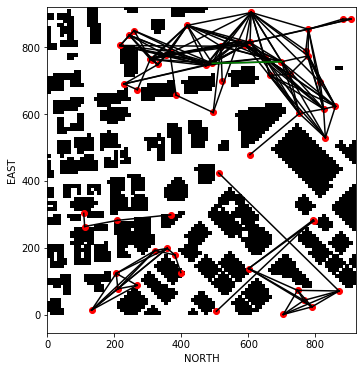

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sampling import Sampler
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

import sys
import pkg_resources
import networkx as nx

plt.rcParams['figure.figsize'] = 6,6

filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=3)
print(data)

from sampling import Sampler

sampler = Sampler(data)
polygons = sampler._polygons

# Example: sampling 100 points and removing
# ones conflicting with obstacles.
nodes = sampler.sample(100)
print(len(nodes))

import numpy.linalg as LA
from sklearn.neighbors import KDTree


def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

nds = np.array(nodes)

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nds)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]

        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue

            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
    return g

import time
t0 = time.time()
g = create_graph(nodes, 20)
print('graph took {0} seconds to build'.format(time.time()-t0))

print("Number of edges", len(g.edges))

from grid import create_grid

grid = create_grid(data, sampler._zmax, 1)

def heuristic(n1, n2):
    # TODO: finish
    return LA.norm(np.array(n2) - np.array(n1))


def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""

    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False

    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)

                if next_node not in visited:
                    visited.add(next_node)
                    queue.put((new_cost, next_node))

                    branch[next_node] = (new_cost, current_node)

    path = []
    path_cost = 0
    if found:

        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])

    return path[::-1], path_cost

start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]

path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')

# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')

# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()
